In [1]:
from __future__ import print_function
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools
DrawingOptions.bondLineWidth=1.8
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import scipy as scp

#### Set up data frame for features

In [2]:
# Final PDB files for Rosetta-compatible process
PDB_df = pd.read_csv('./final_PDBs.csv'\
                     ,index_col=0)
PDB_df.head()

,mol2_path,pdb_path
id,,
02J,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...
03M,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...
04X,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...
05N,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...
07V,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...


In [3]:
# All SMILES
smiles_df = pd.read_csv('./Components-smiles-oe.smi',\
                       sep='\t',names=np.array(['smi','id','name']),index_col=1)
smiles_df.head()

,smi,name
id,,
000,COC(=O)O,methyl hydrogen carbonate
001,COc1cc(cc(c1OC)OC)C(C(=O)N2CCCCC2C(=O)OC(CCCc3...,"1-[2,2-difluoro-2-(3,4,5-trimethoxy-phenyl)-ac..."
002,CCC(C)C(C(=O)NC(CC(C)C)C(=O)O)NC(=O)C(Cc1ccccc...,n-[(2r)-2-benzyl-4-(hydroxyamino)-4-oxobutanoy...
003,CC(C)CN1c2c(c(n(n2)Cc3cccc4c3cccc4)c5ccncc5)C(...,5-methyl-7-(2-methylpropyl)-2-(naphthalen-1-yl...
004,c1ccc(cc1)C(C(=O)O)N,(2s)-amino(phenyl)ethanoic acid


In [4]:
# All PDB counts
LE_selected_ligands_df = pd.read_csv('./LE_counts_df_selected_ParseLigandsPBDBind.tab'\
                                     ,sep='\t',index_col=0)
LE_selected_ligands_df.head()

,count,name,formula,Cn_OK,bin
id,,,,,
DOG,5,DIGOXIGENIN,C23 H34 O5,True,0
AKV,1,"{3-[(1R,3S)-1,3-DIHYDROXYPENTYL]-4,5,9,10-TETR...",C22 H22 O8,True,-1
CRP,2,"((1RS,3SR)-2,2-DICHLORO-N-[(R)-1-(4-CHLOROPHEN...",C15 H18 Cl3 N O,True,0
OFM,2,"[(4Z)-2-{(2R,5R)-2-[(1S)-1-amino-2-phenylethyl...",C24 H24 N4 O6,True,0
2J8,2,"(4S,11S,18S)-4,11,18-tri(propan-2-yl)-6,13,20-...",C24 H30 N6 O3 Se3,True,0


In [5]:
# Concatenate all above data frames:
PDB_df['name'] = smiles_df.loc[PDB_df.index]['name']
PDB_df['smi'] = smiles_df.loc[PDB_df.index]['smi']
PDB_df['bin'] = LE_selected_ligands_df.loc[PDB_df.index]['bin']
PDB_df['formula'] = LE_selected_ligands_df.loc[PDB_df.index]['formula']
PDB_df.head()

,mol2_path,pdb_path,name,smi,bin,formula
id,,,,,,
02J,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,"5-methyl-1,2-oxazole-3-carboxylic acid",Cc1cc(no1)C(=O)O,0,C5 H5 N O3
03M,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,(5z)-5-[(6-chloro-7-methyl-1h-indol-3-yl)methy...,Cc1c(ccc2c1[nH]cc2C=C3C(=O)N(C(=O)N3)Cc4ccc(c(...,0,C20 H14 Cl F2 N3 O2
04X,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,"(2s)-5-(morpholin-4-ylmethyl)-1,2,3,6-tetrahyd...",C1COCCN1CC2=CCC(NC2)C(=O)O,0,C11 H18 N2 O3
05N,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,"(3r,4r)-4-hydroxy-3-methyl-l-proline",CC1C(CNC1C(=O)O)O,0,C6 H11 N O3
07V,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,(5r)-2-methyl-5-(prop-1-en-2-yl)cyclohex-2-en-...,CC1=CCC(CC1=O)C(=C)C,0,C10 H14 O


In [6]:
# Functions for calculating properties
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

def get_logp(lig_id):
    molecule = Chem.MolFromPDBFile(PDB_df.loc[lig_id]['pdb_path']\
                               ,sanitize=True,removeHs=False)
    refmol = Chem.MolFromMol2File(PDB_df.loc[lig_id]['mol2_path'].replace('%s.mol2'%lig_id,'tmp.mol2')\
                                           ,removeHs=True,sanitize=False)
    molecule = Chem.AssignBondOrdersFromTemplate(refmol,molecule)
    logp,MR = rdMolDescriptors.CalcCrippenDescriptors(molecule)
    return logp

def get_MW(lig_id):
    molecule = Chem.MolFromPDBFile(PDB_df.loc[lig_id]['pdb_path']\
                               ,sanitize=False,removeHs=False)
    MW = Descriptors.ExactMolWt(molecule)
    return MW

def get_charge(lig_id):
    infname = PDB_df.loc[lig_id]['mol2_path']
    f = open(infname,'r')
    flines = [ i[:-1] for i in f.readlines() ]
    record = False
    useful_lines = []
    for line in flines:
            if '@<TRIPOS>BOND' in line:
                    record = False
            if record:
                    useful_lines.append(line)
            if '@<TRIPOS>ATOM' in line:
                    record = True
    partial_charge = sum([ float(i.split()[-1]) for i in useful_lines ])
    return np.rint(partial_charge)

def has_phosphate(lig_id):
    smiles = PDB_df.loc[lig_id]['smi']
    has_phosphate1 = Chem.MolFromSmiles(smiles).HasSubstructMatch(Chem.MolFromSmiles('COP(O)(O)=O'))
    #has_phosphate2 = Chem.MolFromSmiles(smiles).HasSubstructMatch(Chem.MolFromSmiles('COP(O)=O'))
    return (has_phosphate1)

def has_furanose(lig_id):
    smiles = PDB_df.loc[lig_id]['smi']
    has_furanose = Chem.MolFromSmiles(smiles).HasSubstructMatch(Chem.MolFromSmiles('C(C1C(C(C(O1))))'))
    return has_furanose

def has_pyranose(lig_id):
    smiles = PDB_df.loc[lig_id]['smi']
    has_pyranose = Chem.MolFromSmiles(smiles).HasSubstructMatch(Chem.MolFromSmiles('C1CCOCC1'))
    return has_pyranose

def has_sterol(lig_id):
    refmol = Chem.MolFromSmiles(PDB_df.loc[lig_id]['smi'])
    sterol = Chem.MolFromSmiles('C1CCC2C1(CCC3C2CCC4C3(CCC(C4)))')
    mols = (refmol,sterol)
    res = rdFMCS.FindMCS(mols,bondCompare=rdFMCS.BondCompare.CompareAny)
    return ((res.numAtoms == sterol.GetNumAtoms()) and (res.numBonds == sterol.GetNumBonds()))

def has_benzene(lig_id):
    smiles = PDB_df.loc[lig_id]['smi']
    has_benzene = Chem.MolFromSmiles(smiles).HasSubstructMatch(Chem.MolFromSmiles('c1ccccc1'))
    return has_benzene

def has_halide(lig_id):
    smiles = PDB_df.loc[lig_id]['smi']
    refmol = Chem.MolFromSmiles(smiles)
    has_Cl = refmol.HasSubstructMatch(Chem.MolFromSmiles('Cl'))
    has_F = refmol.HasSubstructMatch(Chem.MolFromSmiles('F'))
    has_Br = refmol.HasSubstructMatch(Chem.MolFromSmiles('Br'))
    has_I = refmol.HasSubstructMatch(Chem.MolFromSmiles('I'))
    return any([has_Cl,has_F,has_Br,has_I])

def has_DNA_base(lig_id):
    smiles = PDB_df.loc[lig_id]['smi']
    refmol = Chem.MolFromSmiles(smiles)
    adenine = Chem.MolFromSmiles('C1=NC2=NC=NC(=C2N1)N')
    cytosine = Chem.MolFromSmiles('C1=C(NC(=O)N=C1)N')
    guanine = Chem.MolFromSmiles('C1=NC2=C(N1)C(=O)NC(=N2)N')
    thymine = Chem.MolFromSmiles('CC1=CNC(=O)NC1=O')
    has_adenine = refmol.HasSubstructMatch(adenine)
    has_cytosine = refmol.HasSubstructMatch(cytosine)
    has_guanine = refmol.HasSubstructMatch(guanine)
    has_thymine = refmol.HasSubstructMatch(thymine)
    return any([has_adenine,has_cytosine,has_guanine,has_thymine])

def has_sulfonate(lig_id):
    smiles = PDB_df.loc[lig_id]['smi']
    refmol = Chem.MolFromSmiles(smiles)
    sulfonate = Chem.MolFromSmiles('S(=O)(=O)O')
    return refmol.HasSubstructMatch(sulfonate)

In [7]:
PDB_df['MW'] = np.array( [ get_MW(i) for i in PDB_df.index ] )

In [8]:
# For some reason these molecules can't be processed for logP
failed = []
for i in PDB_df.index:
    try:get_logp(i)
    except: failed.append(i); print('Failed %s'%i)
print(failed)
len(failed)

RDKit ERROR: [11:26:32] Can't kekulize mol.  Unkekulized atoms: 8 15 16 17 18
RDKit ERROR: 


Failed 0JO


RDKit WARNING: [11:26:32] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:32] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:32] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:32] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:32] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:32] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:32] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:32] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:32] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:32] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:32] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:32] WARNING: More than one match

RDKit ERROR: [11:26:33] WARNING: More th[11:26:34] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 8 10 11
RDKit ERROR: 
RDKit WARNING: an one matching pattern found - picking one
RDKit WARNING: [11:26:33] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:33] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:33] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:33] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:33] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:33] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:33] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:33] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:33] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:33] WARNING: More th

Failed BEA
Failed C11


RDKit WARNING: [11:26:34] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:34] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:34] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:34] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:34] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:34] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:34] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:34] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:34] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:34] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:34] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:34] WARNING: More than one match

Failed FAS


RDKit ERROR: [11:26:36] WARNING: More than on[11:26:36] Can't kekulize mol.  Unkekulized atoms: 0 1 11
RDKit ERROR: 


Failed GDV


RDKit WARNING: e matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one


Failed KKN


RDKit ERROR: [11:26:37] Explicit valence for atom # 14 C, 5, is greater than permitted


Failed N1C


RDKit WARNING:  WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:36] WARNING: More than one matching patter

Failed PGI


RDKit WARNING: picking one
RDKit WARNING: [11:26:37] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:37] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:37] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:37] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:37] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:37] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:37] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:37] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:37] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:37] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:37] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:37] W

Failed VIB
['0JO', 'BEA', 'C11', 'FAS', 'GDV', 'KKN', 'N1C', 'PGI', 'VIB']


9

In [9]:
new_index = [ i for i in PDB_df.index if i not in failed ]
new_PDB_df = PDB_df.loc[new_index]
new_PDB_df.head()

,mol2_path,pdb_path,name,smi,bin,formula,MW
id,,,,,,,
02J,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,"5-methyl-1,2-oxazole-3-carboxylic acid",Cc1cc(no1)C(=O)O,0,C5 H5 N O3,133.073893
03M,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,(5z)-5-[(6-chloro-7-methyl-1h-indol-3-yl)methy...,Cc1c(ccc2c1[nH]cc2C=C3C(=O)N(C(=O)N3)Cc4ccc(c(...,0,C20 H14 Cl F2 N3 O2,401.285384
04X,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,"(2s)-5-(morpholin-4-ylmethyl)-1,2,3,6-tetrahyd...",C1COCCN1CC2=CCC(NC2)C(=O)O,0,C11 H18 N2 O3,232.177595
05N,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,"(3r,4r)-4-hydroxy-3-methyl-l-proline",CC1C(CNC1C(=O)O)O,0,C6 H11 N O3,148.096820
07V,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,(5r)-2-methyl-5-(prop-1-en-2-yl)cyclohex-2-en-...,CC1=CCC(CC1=O)C(=C)C,0,C10 H14 O,156.151415


In [10]:
new_PDB_df['logp'] = np.array([ get_logp(i) for i in new_PDB_df.index ])

RDKit WARNING: ching pattern found - picking one
RDKit WARNING: [11:26:38] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:38] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:38] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:38] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:38] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:38] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:38] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:38] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:38] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:38] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:38] WARNING: More than one matching pattern found - picking one
RDKit

RDKit WARNING: [11:26:43] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:43] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:43] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:43] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:43] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:43] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:43] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:43] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:43] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:43] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:43] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:43] WARNING: More than one match

RDKit WARNING: [11:26:44] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:44] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:44] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:44] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:44] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:44] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:44] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:44] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:44] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:44] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:44] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:44] WARNING: More than one match

RDKit WARNING: [11:26:45] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:45] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:45] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:45] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:45] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:45] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:45] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:45] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:45] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:45] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:45] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:45] WARNING: More than one match

RDKit WARNING: [11:26:46] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:46] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:46] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:46] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:46] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:46] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:46] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:46] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:46] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:46] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:46] WARNING: More than one matching pattern found - picking one
RDKit WARNING: [11:26:46] WARNING: More than one match

In [11]:
new_PDB_df['charge'] = np.array([ get_charge(i) for i in new_PDB_df.index ])
new_PDB_df['has_phosphate'] = np.array([ has_phosphate(i) for i in new_PDB_df.index ])
new_PDB_df['has_furanose'] = np.array([ has_furanose(i) for i in new_PDB_df.index ])
new_PDB_df['has_pyranose'] = np.array([ has_pyranose(i) for i in new_PDB_df.index ])
new_PDB_df['has_sterol'] = np.array([ has_sterol(i) for i in new_PDB_df.index ])
new_PDB_df['has_benzene'] = np.array([ has_benzene(i) for i in new_PDB_df.index ])
new_PDB_df['has_halide'] = np.array([ has_halide(i) for i in new_PDB_df.index ])
new_PDB_df['has_sulfonate'] = np.array([ has_sulfonate(i) for i in new_PDB_df.index ])
new_PDB_df['has_DNA_base'] = np.array([ has_DNA_base(i) for i in new_PDB_df.index ])

In [12]:
new_PDB_df['path'] = np.array( [ \
'./addPartialChargesConvertParams/'+i+'/'+i+'.params' \
for i in new_PDB_df.index ] )

### Now create 200 clusters from charge, logP, MW and number of reps in the PDB:

In [13]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [14]:
mol_features = new_PDB_df[['charge','logp','MW','bin','has_phosphate','has_furanose',\
                          'has_pyranose','has_sterol','has_benzene','has_halide','has_sulfonate','has_DNA_base']]
scaler = preprocessing.StandardScaler().fit(mol_features)
scaled_features = scaler.transform(mol_features)
kmeans = KMeans(n_clusters=49, random_state=0).fit(scaled_features)
new_PDB_df['cluster'] = kmeans.labels_
np.random.seed(1004)
selected_ligs = []
for i in set(kmeans.labels_):
    id_selected = np.random.choice( new_PDB_df.loc[new_PDB_df['cluster']==i].index,1 )[0]
    selected_ligs.append(id_selected)
print(selected_ligs)

['C38', 'AUB', 'BTN', 'EQU', '5XE', 'OSE', 'CME', 'CDI', 'CTN', 'M7M', '8H6', 'GYP', 'G3A', 'F91', 'MCS', 'IHP', 'I2C', 'AC2', '2ZV', '48Z', 'DHY', 'P5A', '3J4', 'DYH', 'BOG', 'UFG', 'GDS', 'H1L', 'CSF', 'EVT', 'TCH', '5RW', 'M7B', '0FV', 'GNP', 'RET', 'DPV', '9U4', 'MTT', 'DQX', 'BDD', 'PPQ', 'TTG', 'P2H', 'M40', 'OBN', 'A6A', 'AEE', 'EU7']


In [15]:
# Add controls:
final_selected_ligands = new_PDB_df.loc[list(set(selected_ligs + ['EQU','AKV']))]

In [16]:
#final_selected_ligands.to_csv('./50_clust_ligand_feat.csv',sep='\t')

In [17]:
new_PDB_df.head()

,mol2_path,pdb_path,name,smi,bin,formula,MW,logp,charge,has_phosphate,has_furanose,has_pyranose,has_sterol,has_benzene,has_halide,has_sulfonate,has_DNA_base,path,cluster
id,,,,,,,,,,,,,,,,,,,
02J,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,"5-methyl-1,2-oxazole-3-carboxylic acid",Cc1cc(no1)C(=O)O,0,C5 H5 N O3,133.073893,-1.29778,-1.0,False,False,False,False,False,False,False,False,./addPartialChargesConvertParams/02J/02J.params,2
03M,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,(5z)-5-[(6-chloro-7-methyl-1h-indol-3-yl)methy...,Cc1c(ccc2c1[nH]cc2C=C3C(=O)N(C(=O)N3)Cc4ccc(c(...,0,C20 H14 Cl F2 N3 O2,401.285384,4.15584,0.0,False,False,False,False,True,True,False,False,./addPartialChargesConvertParams/03M/03M.params,4
04X,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,"(2s)-5-(morpholin-4-ylmethyl)-1,2,3,6-tetrahyd...",C1COCCN1CC2=CCC(NC2)C(=O)O,0,C11 H18 N2 O3,232.177595,-4.78970,1.0,False,False,False,False,False,False,False,False,./addPartialChargesConvertParams/04X/04X.params,41
05N,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,"(3r,4r)-4-hydroxy-3-methyl-l-proline",CC1C(CNC1C(=O)O)O,0,C6 H11 N O3,148.096820,-4.02430,-0.0,False,False,False,False,False,False,False,False,./addPartialChargesConvertParams/05N/05N.params,41
07V,/home/basantab/NTF2_project/20191216_deNovoNTF...,/home/basantab/NTF2_project/20191216_deNovoNTF...,(5r)-2-methyl-5-(prop-1-en-2-yl)cyclohex-2-en-...,CC1=CCC(CC1=O)C(=C)C,0,C10 H14 O,156.151415,2.48790,0.0,False,False,False,False,False,False,False,False,./addPartialChargesConvertParams/07V/07V.params,18


In [23]:
table_for_excell = pd.read_csv("./50_clust_ligand_feat.csv",sep='\t')
table_for_excell.index = table_for_excell["id"].values

In [24]:
for_plotting = pd.read_csv('./RIFGEN/final_50_lig_docks_w_advantage.csv',sep='\t',index_col=0).sort_values(by='advantage')

In [25]:
for_plotting['2D rep'] = [ get_img(i) for i in for_plotting.index]

RDKit ERROR: [11:26:46] WARNING: More than one matching pattern f[11:33:17] UFFTYPER: Unrecognized charge state for atom: 30
RDKit ERROR: [11:33:19] UFFTYPER: Unrecognized charge state for atom: 17
RDKit ERROR: [11:33:19] UFFTYPER: Unrecognized charge state for atom: 21
RDKit ERROR: [11:33:22] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [11:33:25] UFFTYPER: Unrecognized atom type: S_5+4 (32)
RDKit ERROR: [11:33:26] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [11:33:26] UFFTYPER: Unrecognized atom type: B_ (13)
RDKit ERROR: [11:33:26] UFFTYPER: Unrecognized charge state for atom: 7
RDKit ERROR: [11:33:26] UFFTYPER: Unrecognized charge state for atom: 12
RDKit ERROR: [11:33:26] UFFTYPER: Unrecognized charge state for atom: 17
RDKit ERROR: [11:33:26] UFFTYPER: Unrecognized charge state for atom: 22
RDKit ERROR: [11:33:26] UFFTYPER: Unrecognized charge state for atom: 27
RDKit ERROR: [11:33:26] UFFTYPER: Unrecognized charge state for atom: 32
RDKit ERROR:

In [26]:
MolDrawing.bondLineWidth = 0.01

In [27]:
img=Draw.MolsToGridImage(for_plotting['2D rep'],molsPerRow=5,subImgSize=(400,300),legends=[ "PDB ID: %s Advantage: %0.2f"%(for_plotting.loc[x]["ligand"],for_plotting.loc[x]["advantage"]) for x in for_plotting.index ])

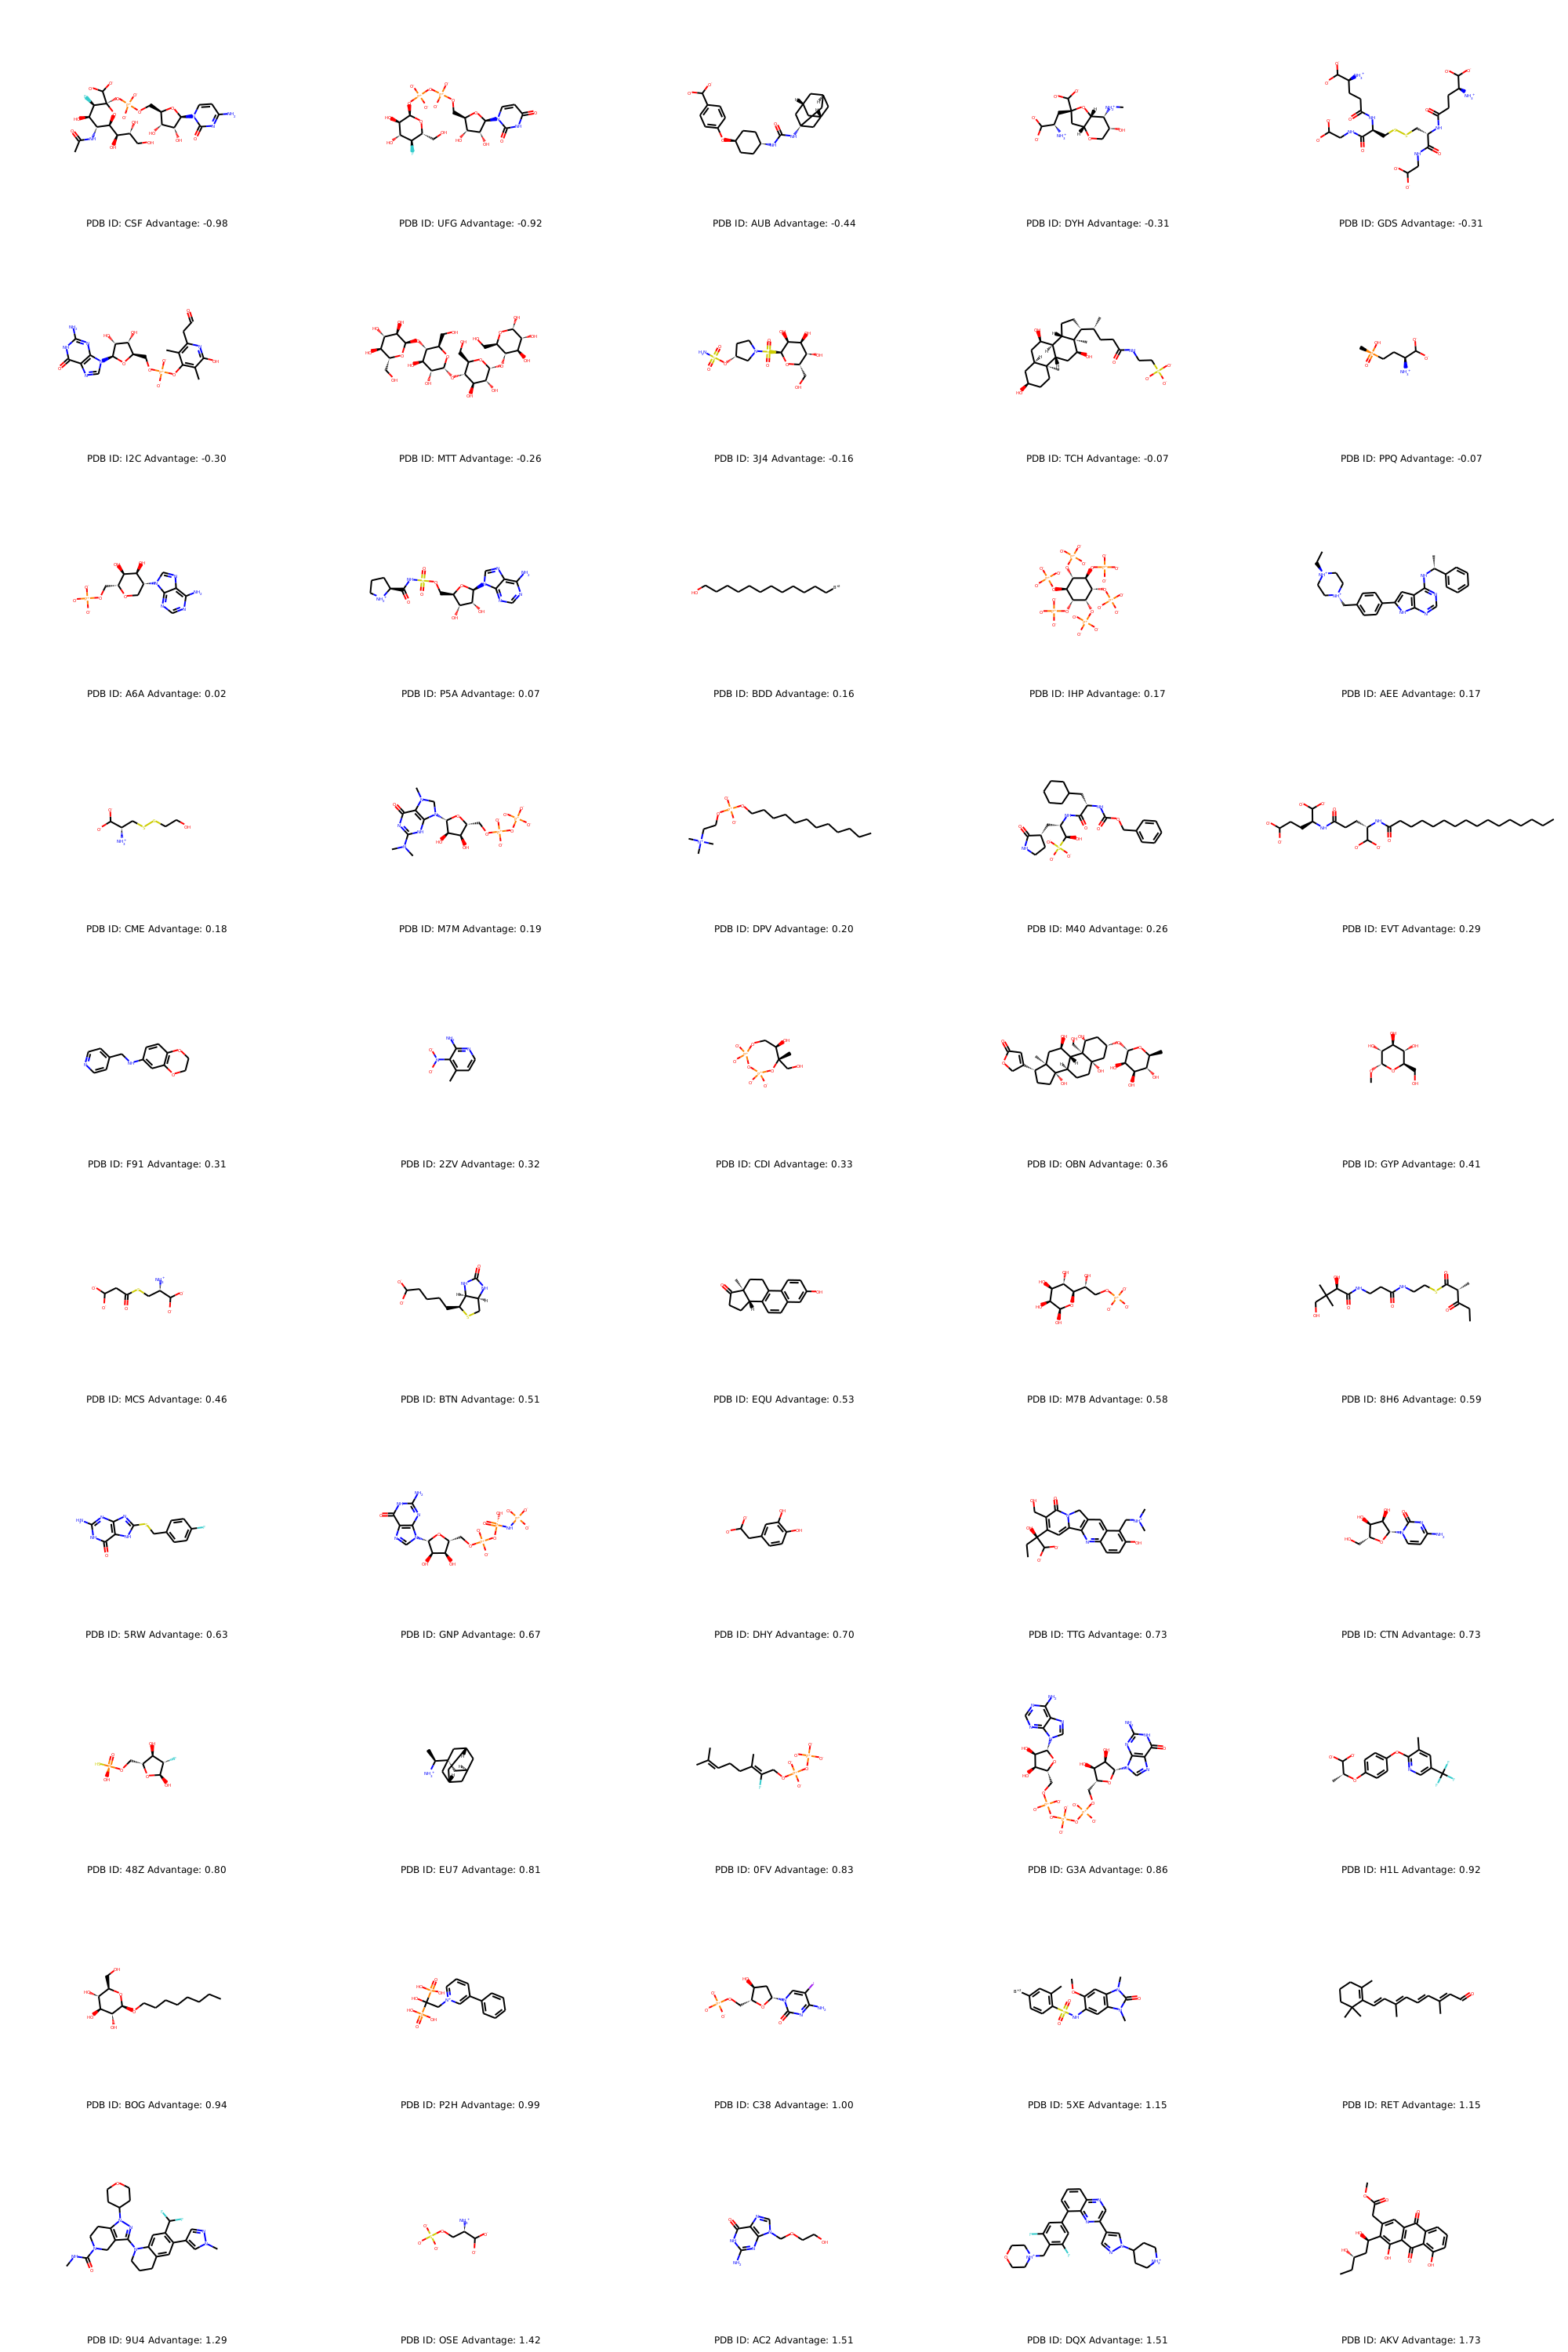

In [28]:
img

In [29]:
def get_img(code):
    refmol = Chem.MolFromMol2File(for_plotting.loc[code]['mol2_path'].replace('%s.mol2'%code,'tmp.mol2'))
    Chem.EmbedMolecule(refmol)
    Chem.Compute2DCoords(refmol)
    #ret = PandasTools.PrintAsBase64PNGString(refmol, renderer='PNG')
    return(refmol)

In [30]:
table_for_excell['2D rep'] = [ get_img(i) for i in table_for_excell.index]

RDKit ERROR: [11:33:31] UFFTYPER: Unrecognized atom type: B_ (4)
RDKit ERROR: [11:33:31] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [11:33:33] UFFTYPER: Unrecognized charge state for atom: 30
RDKit ERROR: [11:33:36] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [11:33:36] UFFTYPER: Unrecognized atom type: S_5+4 (6)
RDKit ERROR: [11:33:37] UFFTYPER: Unrecognized atom type: S_5+4 (31)
RDKit ERROR: [11:33:37] UFFTYPER: Unrecognized atom type: B_ (13)
RDKit ERROR: [11:33:37] UFFTYPER: Unrecognized atom type: S_5+4 (32)
RDKit ERROR: [11:33:38] UFFTYPER: Unrecognized charge state for atom: 3
RDKit ERROR: [11:33:38] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [11:33:38] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [11:33:38] UFFTYPER: Unrecognized charge state for atom: 17
RDKit ERROR: [11:33:38] UFFTYPER: Unrecognized charge state for atom: 21
RDKit ERROR: [11:33:40] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR:

In [9]:
output = table_for_excell[['id', 'name', 'formula', 'MW', 'logp', 'charge', 'has_phosphate', 'has_furanose', 'has_pyranose', 'has_sterol', 'has_benzene', 'has_halide', 'has_sulfonate', 'has_DNA_base', '2D rep']]


In [10]:
PandasTools.SaveXlsxFromFrame(output, './test.xlsx', molCol='2D rep', size=(300, 300))

In [12]:
PandasTools.ChangeMoleculeRendering(frame=output, renderer='PNG')

In [18]:
html_string = PandasTools.patchPandasHTMLrepr(table_for_excell[['id', 'name', 'formula', 'MW', 'logp', 'charge', 'has_phosphate', 'has_furanose', 'has_pyranose', 'has_sterol', 'has_benzene', 'has_halide', 'has_sulfonate', 'has_DNA_base', '2D rep']])